Reffered from https://www.freecodecamp.org/news/an-illustrative-introduction-to-fishers-linear-discriminant-9484efee15ac/

In [21]:
from numpy.linalg import inv,pinv
import numpy as np
from numpy.linalg import eig
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    

In [22]:
class DataSet:
  def __init__(self, data, targets, valid_classes=None):
    if valid_classes is None:
      self.valid_classes = np.unique(targets)
    else:
      self.valid_classes = valid_classes
    #print(self.valid_classes)
    self.number_of_classes = len(self.valid_classes)
    self.data = self.to_dict(data, targets)

  def to_dict(self, data, targets):
    data_dict = {}
    for x, y in zip(data, targets):
      if y in self.valid_classes:
        if y not in data_dict:
          data_dict[y] = [x.flatten()]
        else:
          data_dict[y].append(x.flatten())

    for i in self.valid_classes:
      data_dict[i] = np.asarray(data_dict[i])

    return data_dict

  def get_data_by_class(self, class_id):
    if class_id in self.valid_classes:
      return self.data[class_id]
    else:
      raise ("Class not found.")

  def get_data_as_dict(self):
    return self.data

  def get_all_data(self):
    data = []
    labels = []
    for label, class_i_data in self.data.items():
      data.extend(class_i_data)
      labels.extend(class_i_data.shape[0] * [label])
    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, labels

In [23]:
class LDAClassifier:
  
  def __init__(self, projection_dim):
    self.projection_dim = projection_dim
    self.W = None # weights
    self.g_means, self.g_covariance, self.priors = None, None, None

  def fit(self,X):
    means_k = self.__compute_means(X)

    Sks = []
    for class_i, m in means_k.items():
      sub = np.subtract(X[class_i], m)
      Sks.append(np.dot(np.transpose(sub), sub))

    Sks = np.asarray(Sks)
    Sw = np.sum(Sks, axis=0) # shape = (D,D)

    Nk = {}
    sum_ = 0
    for class_id, data in X.items():
      Nk[class_id] = data.shape[0]
      sum_ += np.sum(data, axis=0)

    self.N = sum(list(Nk.values()))

    # m is the mean of the total data set
    m = sum_ / self.N

    SB = []
    for class_id, mean_class_i in means_k.items():
      sub_ = mean_class_i - m
      SB.append(np.multiply(Nk[class_id], np.outer(sub_, sub_.T)))
    
    # between class covariance matrix shape = (D,D). D = input vector dimensions
    SB = np.sum(SB, axis=0)  # sum of K (# of classes) matrices

    matrix = np.dot(pinv(Sw), SB)
    # find eigen values and eigen-vectors pairs for np.dot(pinv(SW),SB)
    eigen_values, eigen_vectors = eig(matrix)
    print("eigen_values:", eigen_values.shape)
    print("eigen_vectors:", eigen_vectors.shape)

    eiglist = [(eigen_values[i], eigen_vectors[:, i]) for i in range(len(eigen_values))]

    # sort the eigvals in decreasing order
    eiglist = sorted(eiglist, key=lambda x: x[0], reverse=True)

    # take the first num_dims eigvectors
    self.W = np.array([eiglist[i][1] for i in range(self.projection_dim)])
    self.W = np.asarray(self.W).T

    # get parameter of the Gaussian distribution
    self.g_means, self.g_covariance, self.priors = self.gaussian(X)

  # Returns the parameters of the Gaussian distributions
  def gaussian(self, X):
    means = {}
    covariance = {}
    priors = {}  # p(Ck)
    for class_id, values in X.items():
      proj = np.dot(values, self.W)
      means[class_id] = np.mean(proj, axis=0)
      covariance[class_id] = np.cov(proj, rowvar=False)
      # estimate the priors using fractions of the training set data points in each of the classes.
      priors[class_id] = values.shape[0] / self.N
    return means, covariance, priors


  def gaussian_distribution(self, x, u, cov):
    scalar = (1. / ((2 * np.pi) ** (x.shape[0] / 2.))) * (1 / np.sqrt(np.linalg.det(cov)))
    x_sub_u = np.subtract(x, u)
    return scalar * np.exp(-np.dot(np.dot(x_sub_u, inv(cov)), x_sub_u.T) / 2.)

  def score(self,X,y):
    proj = self.project(X)
    gaussian_likelihoods = []
    classes = sorted(list(self.g_means.keys()))
    for x in proj:
      row = []
      for c in classes:  # number of classes
        res = self.priors[c] * self.gaussian_distribution(x, self.g_means[c], self.g_covariance[c])  # Compute the posterios P(Ck|x) prob of a class k given a point x
        row.append(res)

      gaussian_likelihoods.append(row)

    gaussian_likelihoods = np.asarray(gaussian_likelihoods)
    
    # assign x to the class with the largest posterior probability
    predictions = np.argmax(gaussian_likelihoods, axis=1)
    return np.sum(predictions == y) / len(y), predictions, proj

  def project(self,X):
    return np.dot(X, self.W)

  def __compute_means(self, X):
    # Compute the means for each class k=1,2,3...K
    # If the dataset has K classes, then, self.means_k.shape = [# of records, K]
    means_k = {}
    for class_i, input_vectors in X.items():
      means_k[class_i] = np.mean(input_vectors, axis=0)
    return means_k

In [24]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

train_dataset = DataSet(x_train, y_train)
inputs, targets = train_dataset.get_all_data()

print(inputs.shape,targets.shape)

clf = LDAClassifier(projection_dim=2)
clf.fit(train_dataset.get_data_as_dict())

acc = clf.score(inputs,targets)[0]
print("Train acc:", acc)

(60000, 784) (60000,)
eigen_values: (784,)
eigen_vectors: (784, 784)
Train acc: 0.57645


Test acc: 0.565


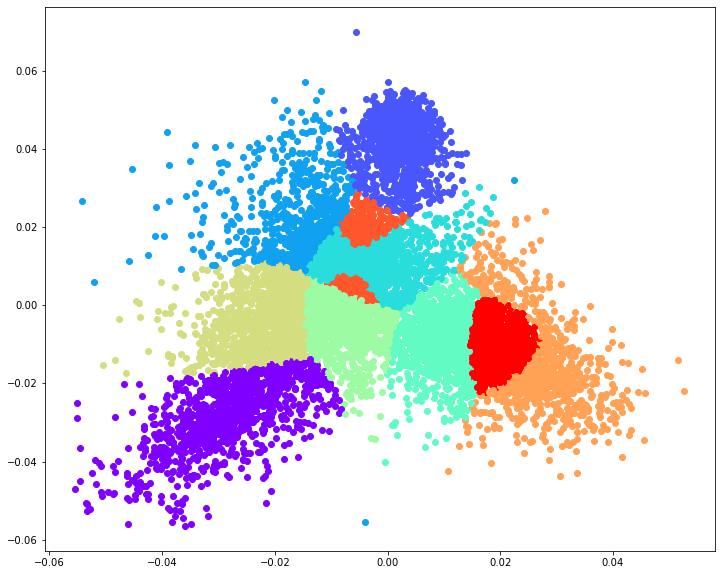

In [25]:
test_dataset = DataSet(x_test, y_test)
inputs, targets = test_dataset.get_all_data()

acc, predictions, proj = clf.score(inputs,targets)
print("Test acc:", acc)

classes = list(np.unique(y_test))
colors = cm.rainbow(np.linspace(0, 1, len(classes)))
plotlabels = {classes[c] : colors[c] for c in range(len(classes))}

plt.figure(figsize=(12,10))
for point,pred in zip(proj,predictions):
  plt.scatter(point[0],point[1],color=plotlabels[pred])
plt.show()

In [26]:
clf = LDAClassifier(projection_dim=3)
clf.fit(train_dataset.get_data_as_dict())

inp, targetVar = test_dataset.get_all_data()
acc, predictions, proj = clf.score(inputs,targets)
print("Test acc:", acc*100,'%')

eigen_values: (784,)
eigen_vectors: (784, 784)
Test acc: 74.24 %


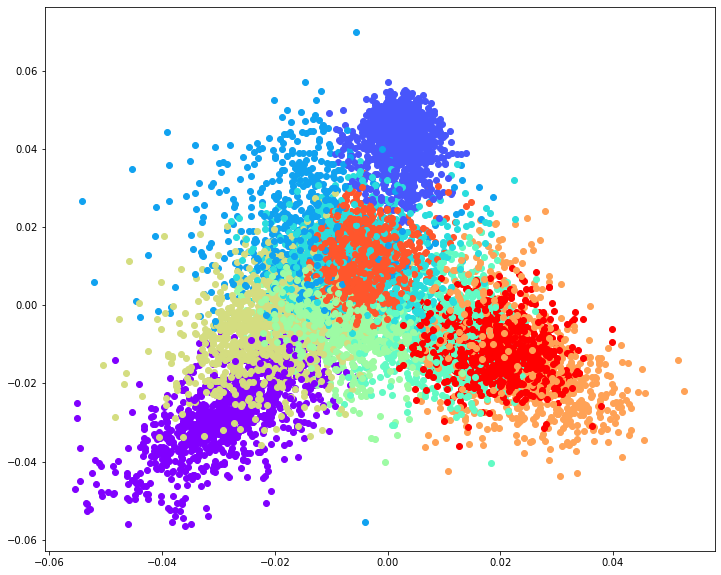

In [27]:
classes2D = list(np.unique(y_test))
colors = cm.rainbow(np.linspace(0, 1, len(classes2D)))
plotlabels = {classes2D[c] : colors[c] for c in range(len(classes2D))}

plt.figure(figsize=(12,10))
for point,pred in zip(proj,predictions):
  plt.scatter(point[0],point[1],color=plotlabels[pred])
plt.show()


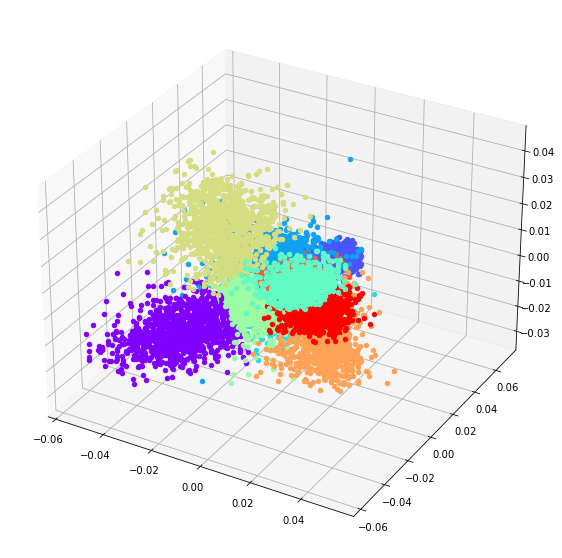

In [28]:
Fischerclass = list(np.unique(y_test))
colors = cm.rainbow(np.linspace(0, 1, len(Fischerclass)))
plotlabels = {Fischerclass[c] : colors[c] for c in range(len(Fischerclass))}

figure = plt.figure(figsize=(12,10))
axis =figure.add_subplot(111,projection='3d')
axis.mouse_init()

for point,pred in zip(proj,predictions):
  axis.scatter(point[0],point[1],point[2],color=plotlabels[pred])

plt.show()